In [1]:
import numpy as np
import os,sys


sys.path.append('../..')
sys.path.append('../../../RL_lib/Agents/PPO')
sys.path.append('../../../RL_lib/Utils')

%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects/AAS-18-290-6DOF-master/AAS-18-290_6DOF_journal/Run/Run_4km_terminal


In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Load Policy

6dof dynamics model
Quaternion_attitude
Thruster Config Shape:  (4, 6) 4
Inertia Tensor:  [[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
Lander Model: 
 - apf_v0:  70
 - apf_vf1:  [ 0.  0. -2.]
 - apf_vf2:  [ 0.  0. -1.]
 - apf_atarg:  15.0
 - apf_tau1:  20
 - apf_tau2:  100.0
Reward_terminal
queue fixed
Flat Constraint
Attitude Constraint


<IPython.core.display.Javascript object>


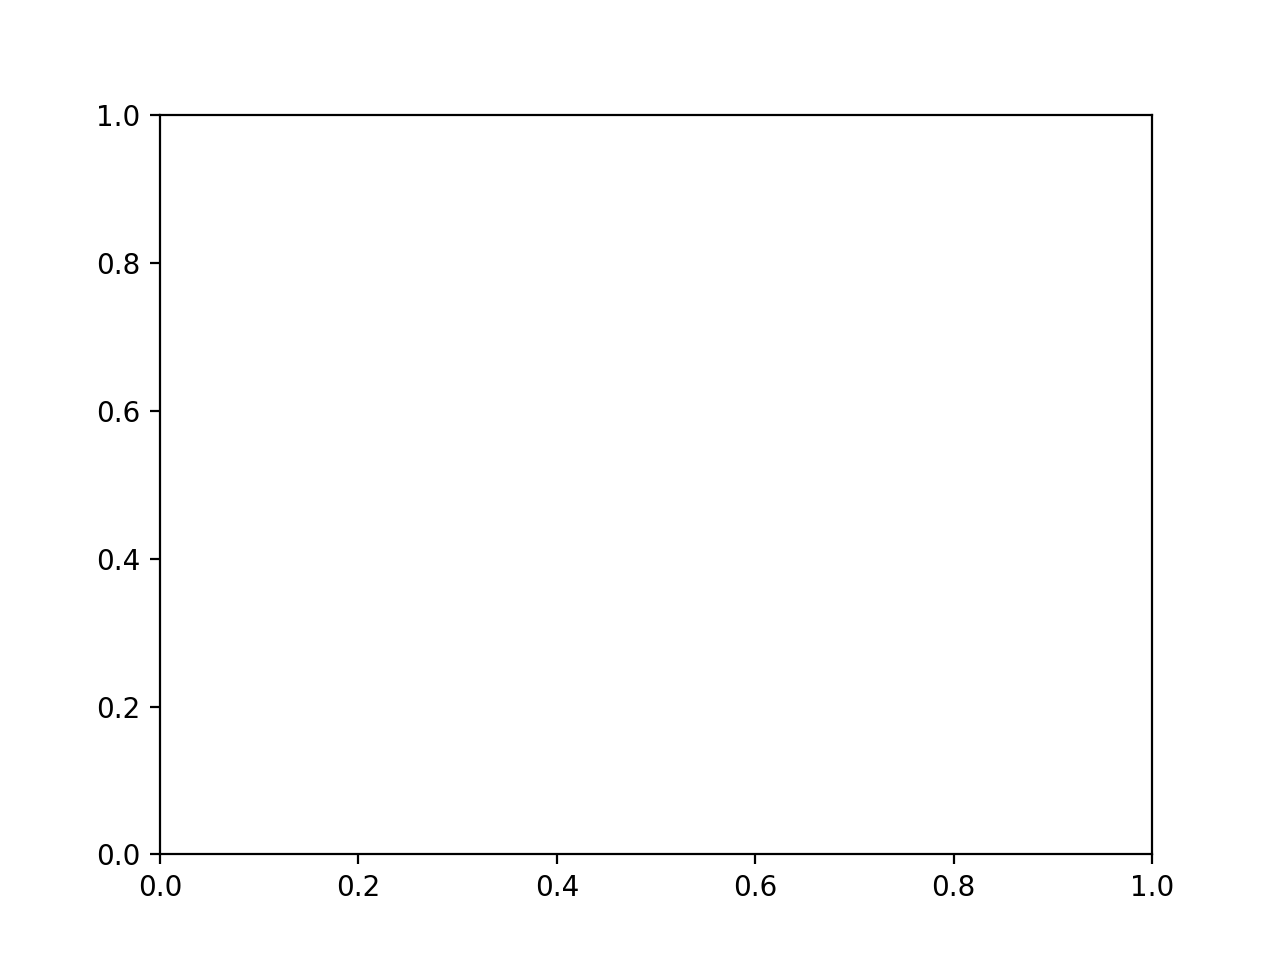

<IPython.core.display.Javascript object>


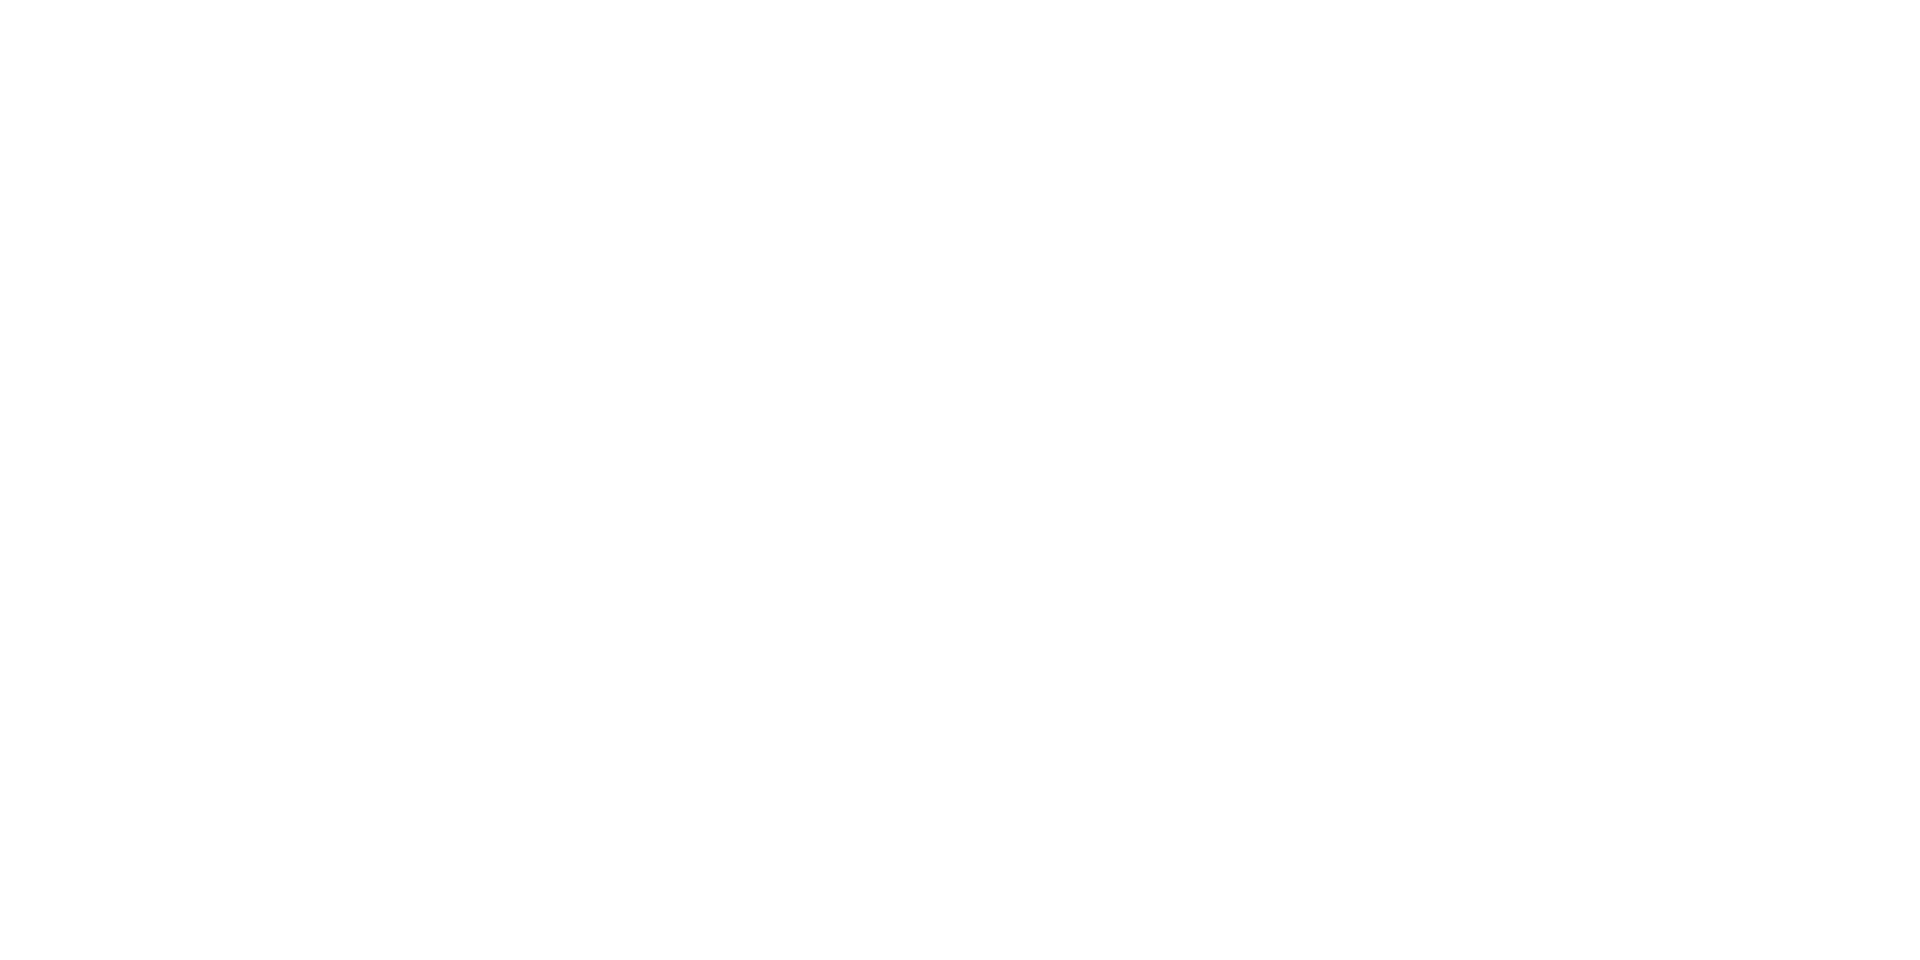

<IPython.core.display.Javascript object>


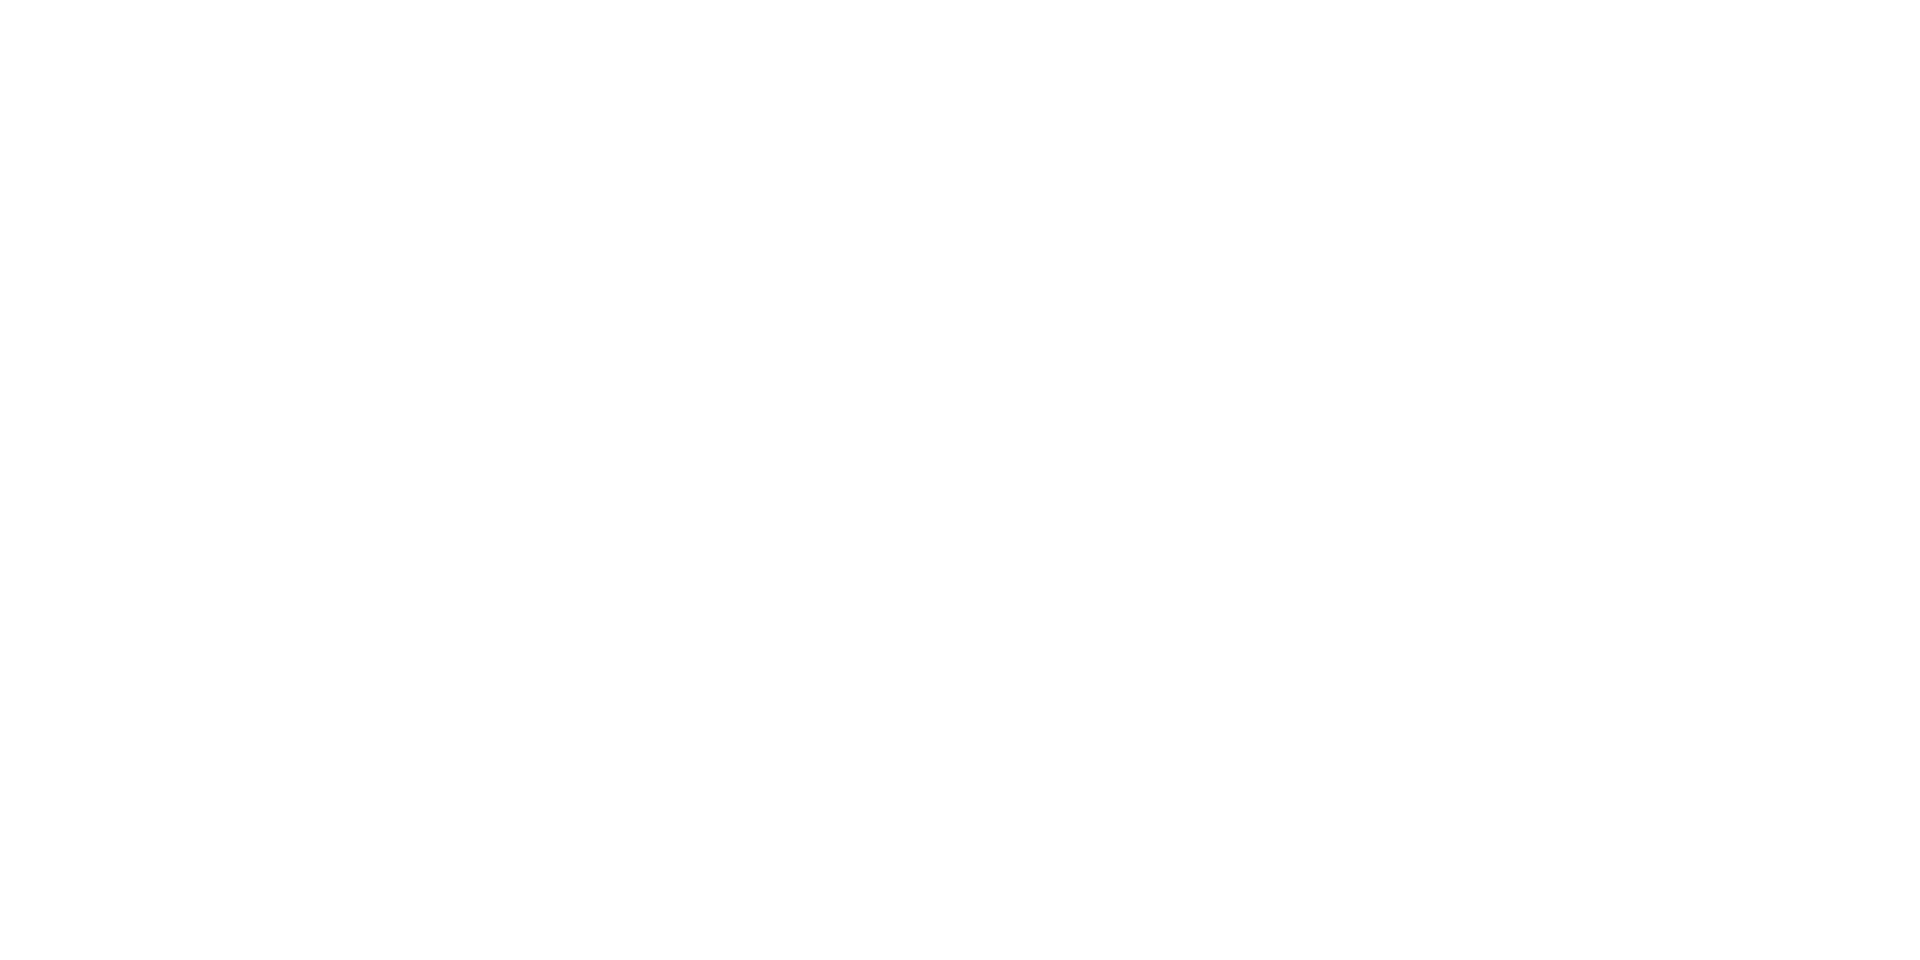

<IPython.core.display.Javascript object>


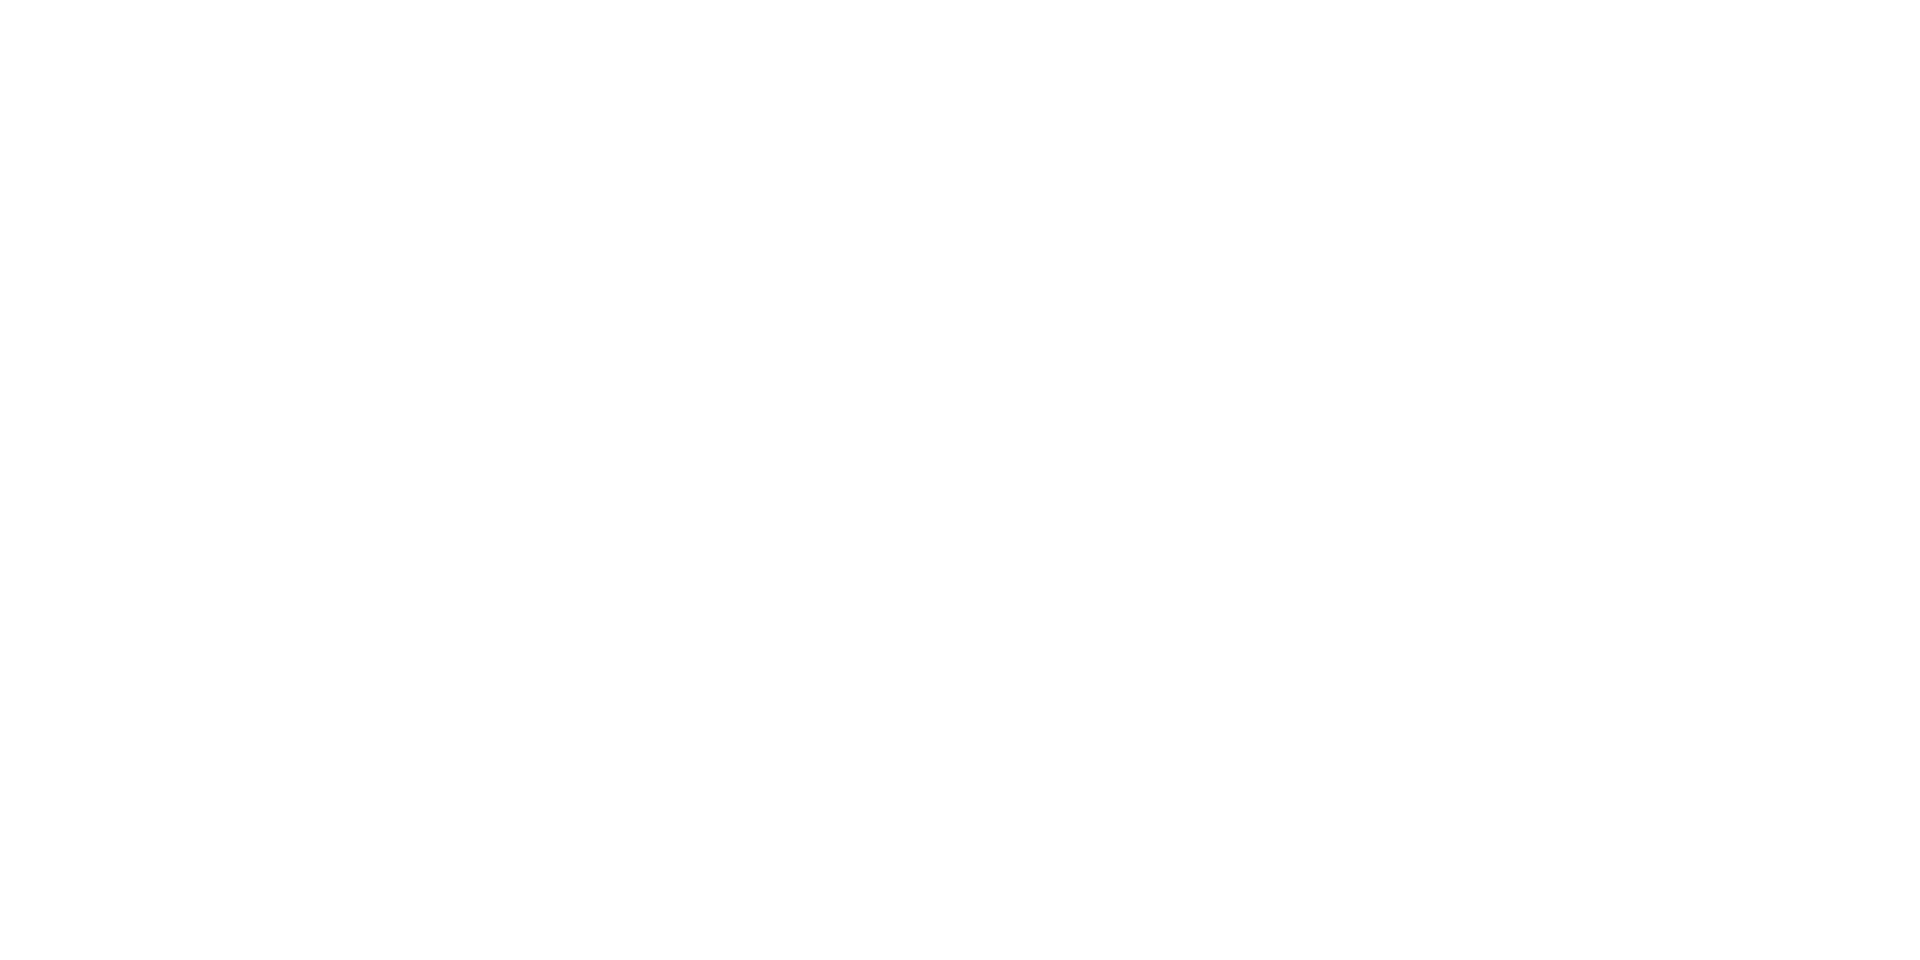

<IPython.core.display.Javascript object>


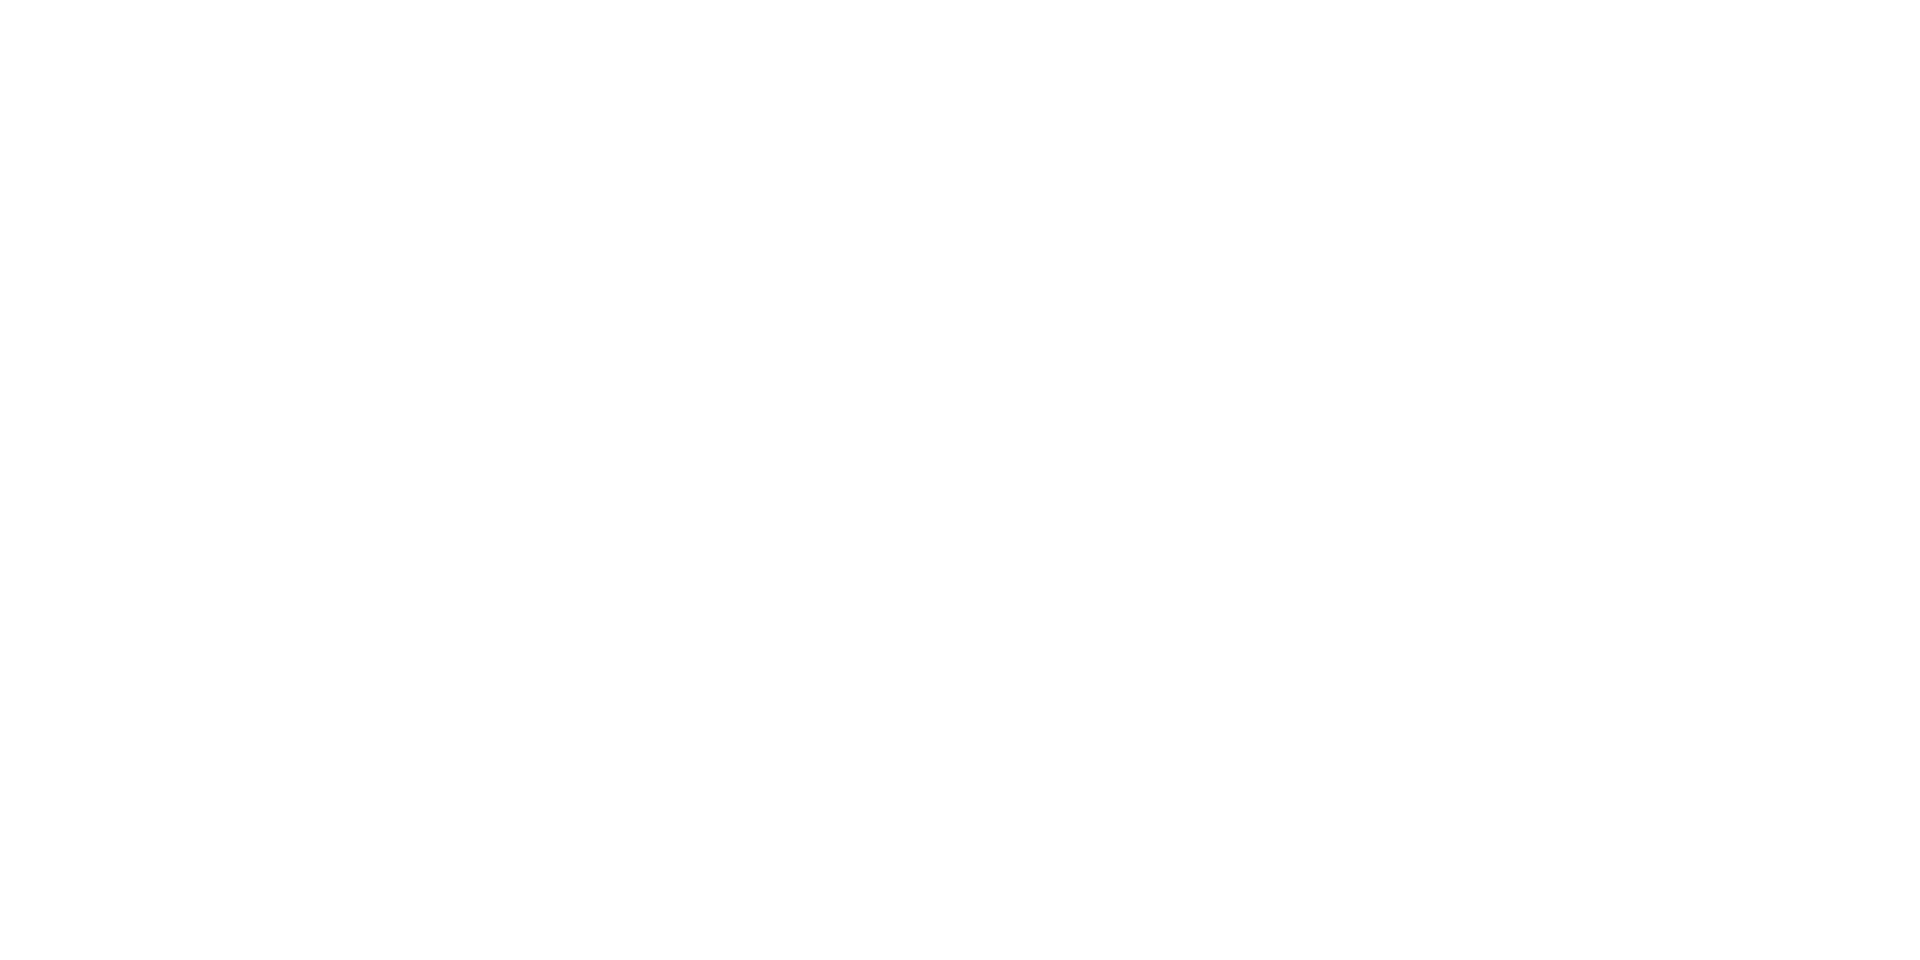

<IPython.core.display.Javascript object>


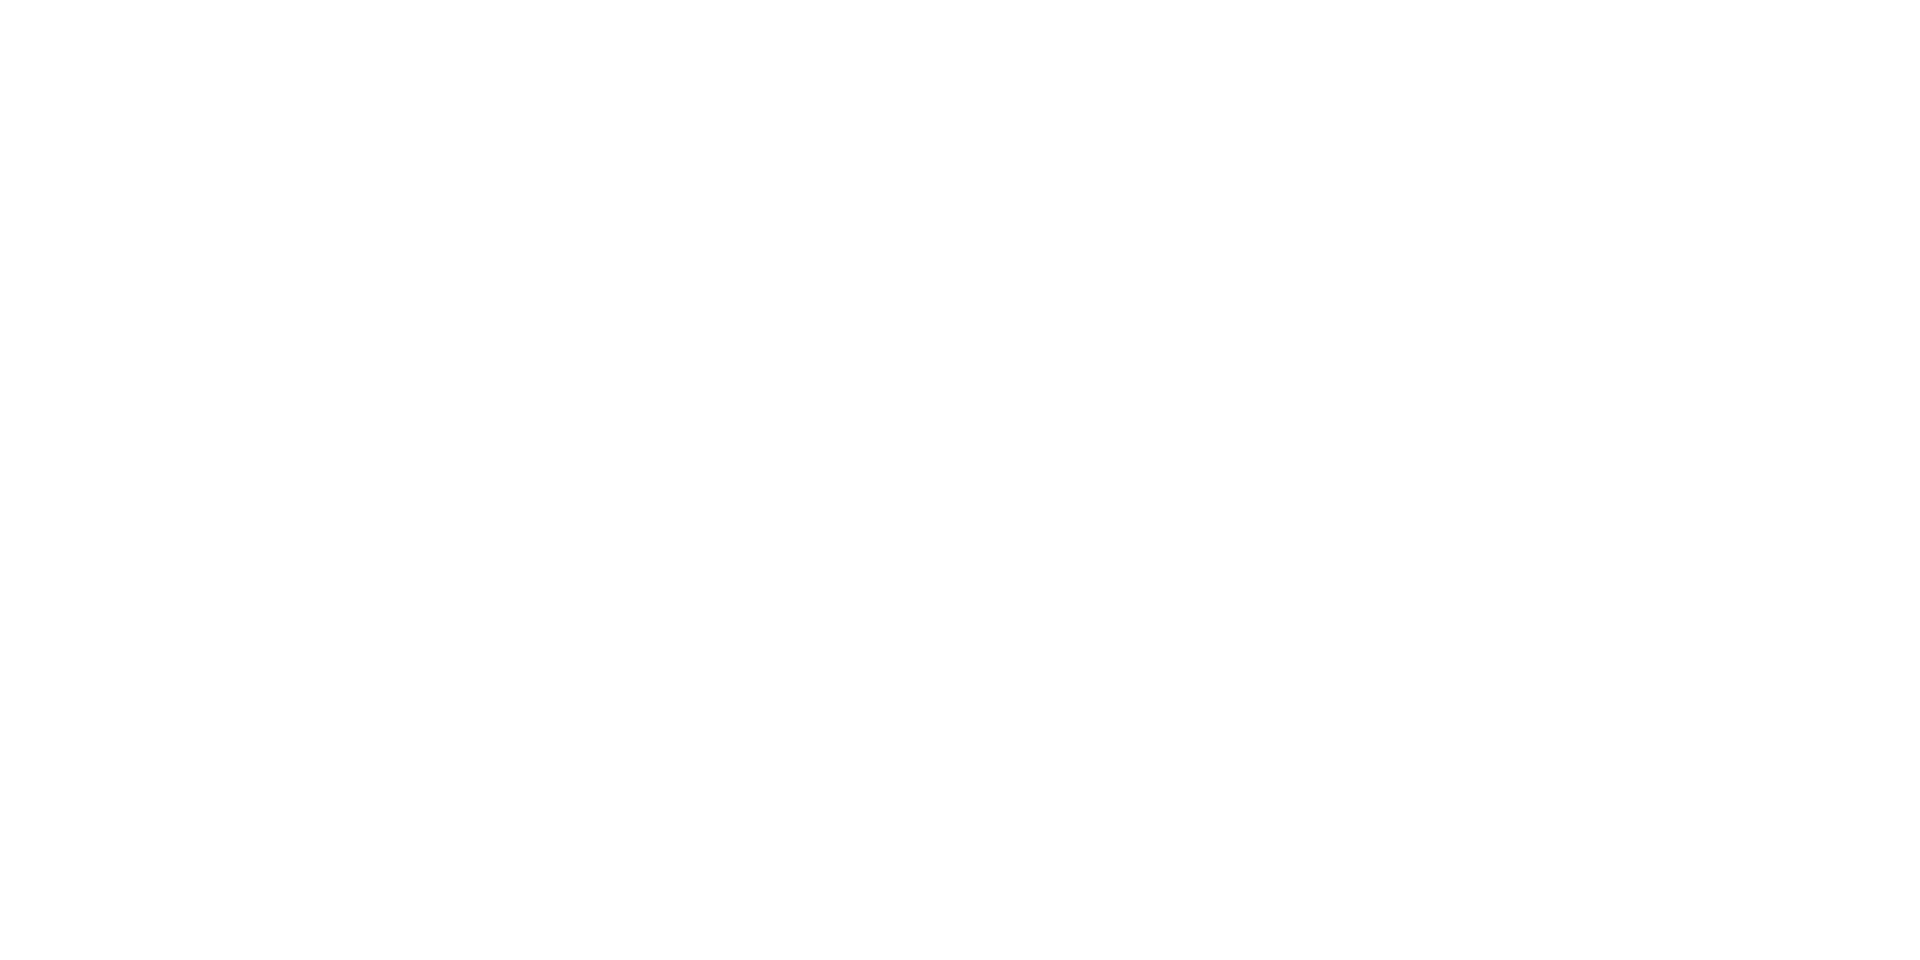

<IPython.core.display.Javascript object>


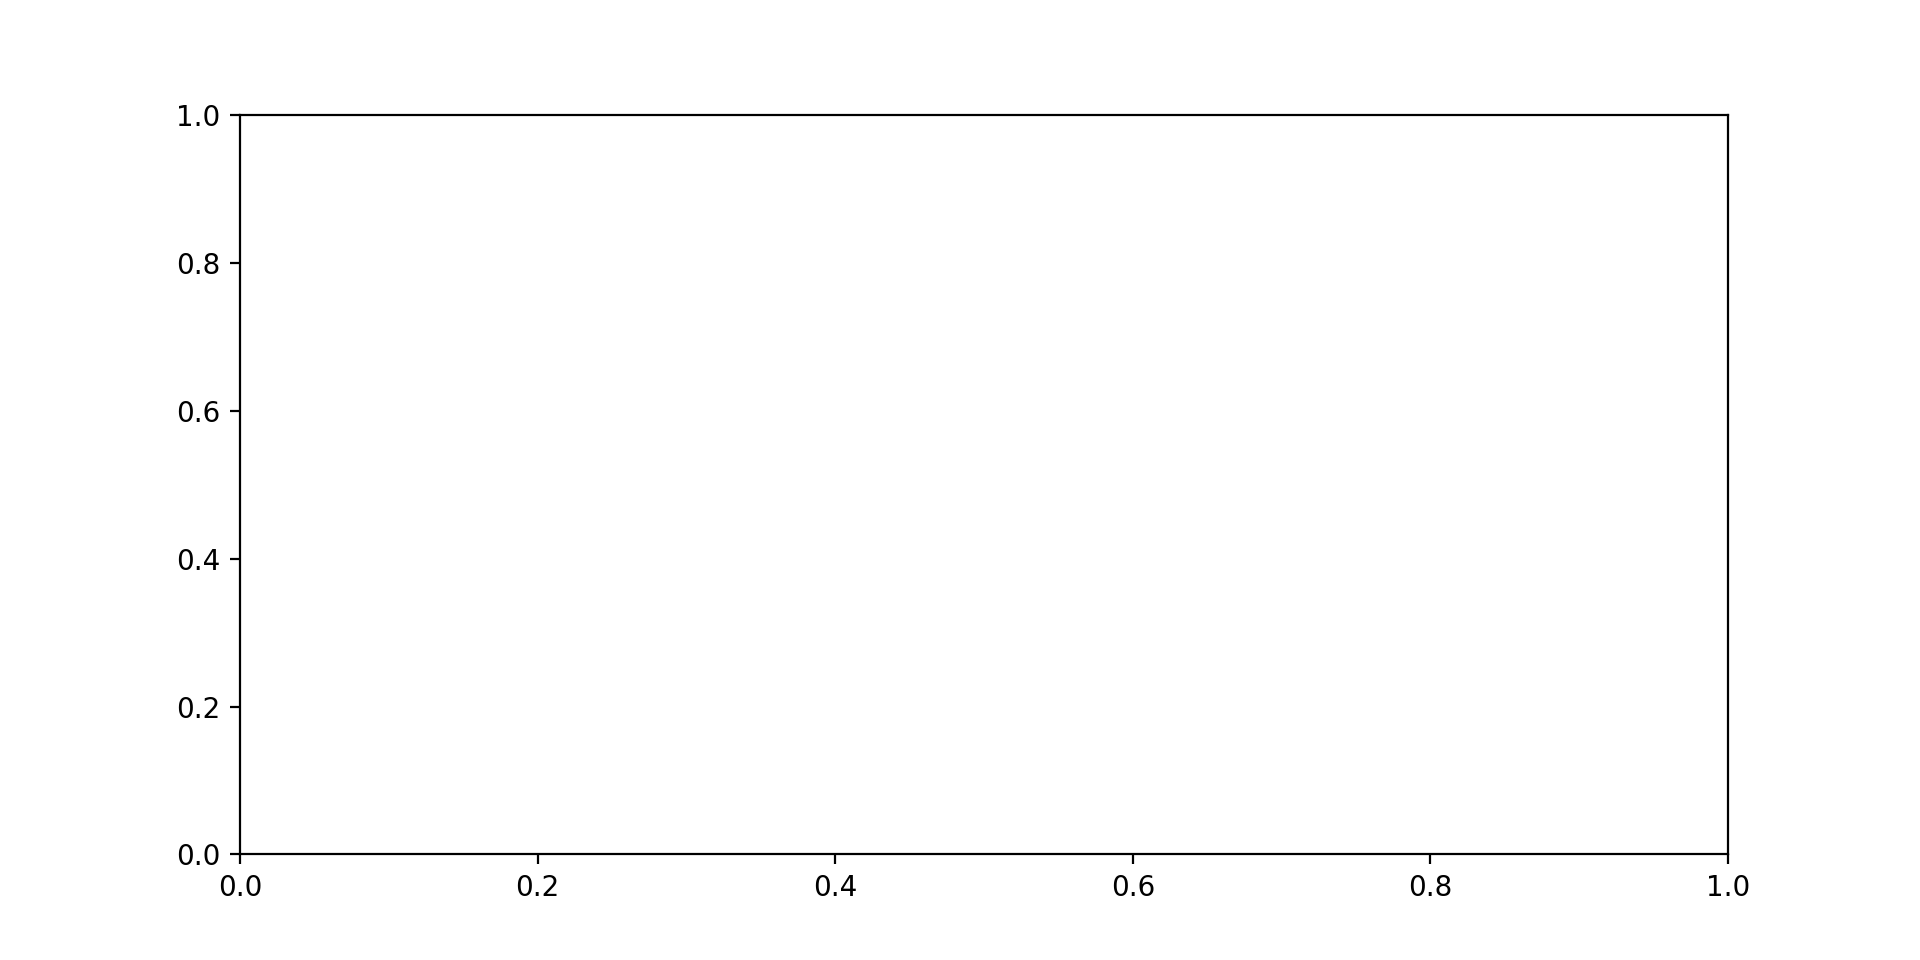

lander env att 2 fixed
Landing_icgen:
    downrange                   :  (0, 2000, -70, -10)
    crossrange                  :  (-1000, 1000, -30, 30)
    altitude                    :  (2300, 2400, -90, -70)
PPO Policy 1
Policy Params -- h1: 120, h2: 69, h3: 40, lr: 0.000108, logvar_speed: 8
[[-1.]
 [ 0.]
 [ 1.]]
10
Actor Test Mode:  False
clip param:  0.1
dict_keys(['means/bias:0', 'h3/kernel:0', 'h2/kernel:0', 'means/kernel:0', 'h3/bias:0', 'h2/bias:0', 'h1/bias:0', 'logvars:0', 'h1/kernel:0'])


In [3]:
from env import Env
from reward_terminal_mdr  import Reward
import env_utils as envu
import attitude_utils as attu
from dynamics_model import Dynamics_model
from lander_model import Lander_model
from ic_gen import Landing_icgen
from agent_mdr2 import Agent
from policy_ppo import Policy
from value_function import Value_function
from utils import Mapminmax,Logger,Scaler
from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from attitude_constraint import Attitude_constraint
from thruster_model import Thruster_model

logger = Logger()
dynamics_model = Dynamics_model()
attitude_parameterization = attu.Quaternion_attitude()

thruster_model = Thruster_model()
thruster_model.max_thrust = 5000
thruster_model.min_thrust = 1000

lander_model = Lander_model(thruster_model, attitude_parameterization=attitude_parameterization,
                           apf_v0=70, apf_atarg=15., apf_tau2=100.)
lander_model.get_state_agent = lander_model.get_state_agent_tgo_alt

reward_object = Reward(tracking_bias=0.01,tracking_coeff=-0.01, fuel_coeff=-0.05, debug=False, landing_coeff=10.)

glideslope_constraint = Glideslope_constraint(gs_limit=-1.0)
shape_constraint = Flat_constraint()
attitude_constraint = Attitude_constraint(attitude_parameterization, 
                                          attitude_penalty=-100,attitude_coeff=-10,
                                         attitude_limit=(10*np.pi, np.pi/2-np.pi/16, np.pi/2-np.pi/16))
env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          attitude_constraint=attitude_constraint,
          tf_limit=120.0,print_every=10)


env.ic_gen = Landing_icgen(mass_uncertainty=0.05, 
                           g_uncertainty=(0.0,0.0), 
                           attitude_parameterization=attitude_parameterization,
                           l_offset=0.,
                           adapt_apf_v0=True,
                           inertia_uncertainty_diag=100.0, 
                           inertia_uncertainty_offdiag=10.0,
                           downrange = (0,2000 , -70, -10), 
                           crossrange = (-1000,1000 , -30,30),  
                           altitude = (2300,2400,-90,-70),
                           yaw   = (-np.pi/8, np.pi/8, 0.0, 0.0) ,
                           pitch = (np.pi/4-np.pi/8, np.pi/4+np.pi/16, -0.01, 0.01),
                           roll  = (-np.pi/8, np.pi/8, -0.01, 0.01))

env.ic_gen.show()


obs_dim = 12
act_dim = 4

policy = Policy(obs_dim,act_dim,kl_targ=0.001,epochs=20, beta=0.1, shuffle=True, servo_kl=True)
import utils
fname = "optimize_4km"
input_normalizer = utils.load_run(policy,fname)
print(input_normalizer)

# 9 square km

In [4]:
policy.test_mode=True
env.ic_gen = Landing_icgen(mass_uncertainty=0.05, g_uncertainty=(0.0,0.0),
                           adapt_apf_v0=True,
                           attitude_parameterization=attitude_parameterization,
                           downrange = (0,3000 , -70, -10), 
                           crossrange = (-1500,1500 , -30,30),  
                           altitude = (2300,2400,-90,-70),
                           yaw   = (-np.pi/8, np.pi/8, 0.0, 0.0) ,
                           pitch = (np.pi/4-np.pi/8, np.pi/4+np.pi/16, -0.0, 0.0),
                           roll  = (-np.pi/8, np.pi/8, -0.0, 0.0),
                          noise_u=100*np.ones(3), noise_sd=100*np.ones(3))
env.test_policy_batch(policy,input_normalizer,20000,print_every=100)

i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |9634.21 |3292.77 |3464.10 |20000.00 |    60
glideslope | 3.087 |37.937 | 0.611 |6755.795 |    76
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4    -0.3    -0.0 |     1.1     1.2     0.0 |    -1.9    -3.9    -0.0 |     4.0     3.4    -0.0
velocity |   0.061  -0.013  -0.922 |   0.027   0.046   0.103 |  -0.020  -0.155  -1.239 |   0.120   0.139  -0.451
fuel     |304.17 | 24.79 |264.42 |357.00
attitude_321 |   0.007  -0.015   0.002 |   0.183   0.011   0.013 |  -0.492  -0.049  -0.025 |   0.425   0.014   0.048
w        |   0.002  -0.005   0.000 |   0.025   0.016   0.000 |  -0.082  -0.063  -0.000 |   0.072   0.037   0.000
glideslope |  21.484 |   9.551 |   7.774 |  61.438
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |9688.05 |3391.32 |3464.10 |20000.00 |    60
glideslope | 3.167 |29.436 | 0.513 |6755.795 |    76
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Fin

i :  1200
Cumulative Stats (mean,std,max,argmax)
thrust   |9667.58 |3368.80 |3464.10 |20000.00 |    60
glideslope | 2.892 |14.657 | 0.513 |6755.795 |    76
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.2    -0.2    -0.0 |     1.1     1.2     0.0 |    -2.4    -5.8    -0.1 |     5.9     3.6    -0.0
velocity |   0.065  -0.014  -0.927 |   0.026   0.040   0.091 |  -0.023  -0.155  -1.324 |   0.139   0.139  -0.451
fuel     |307.91 | 25.42 |259.40 |401.96
attitude_321 |   0.003  -0.016   0.003 |   0.174   0.011   0.013 |  -0.564  -0.055  -0.032 |   0.499   0.028   0.053
w        |  -0.002  -0.008   0.000 |   0.026   0.016   0.000 |  -0.106  -0.096  -0.000 |   0.092   0.038   0.000
glideslope |  22.602 |  17.494 |   7.774 | 352.829
i :  1300
Cumulative Stats (mean,std,max,argmax)
thrust   |9659.78 |3371.03 |3464.10 |20000.00 |    60
glideslope | 2.860 |14.185 | 0.513 |6755.795 |    76
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

KeyboardInterrupt: 

In [6]:
def plot_traj(ax, trajectory,linewidth=0.1):
    trajectory = np.asarray(trajectory)
    ax.plot(trajectory[:,0],trajectory[:,1],trajectory[:,2],linewidth=linewidth)

<IPython.core.display.Javascript object>


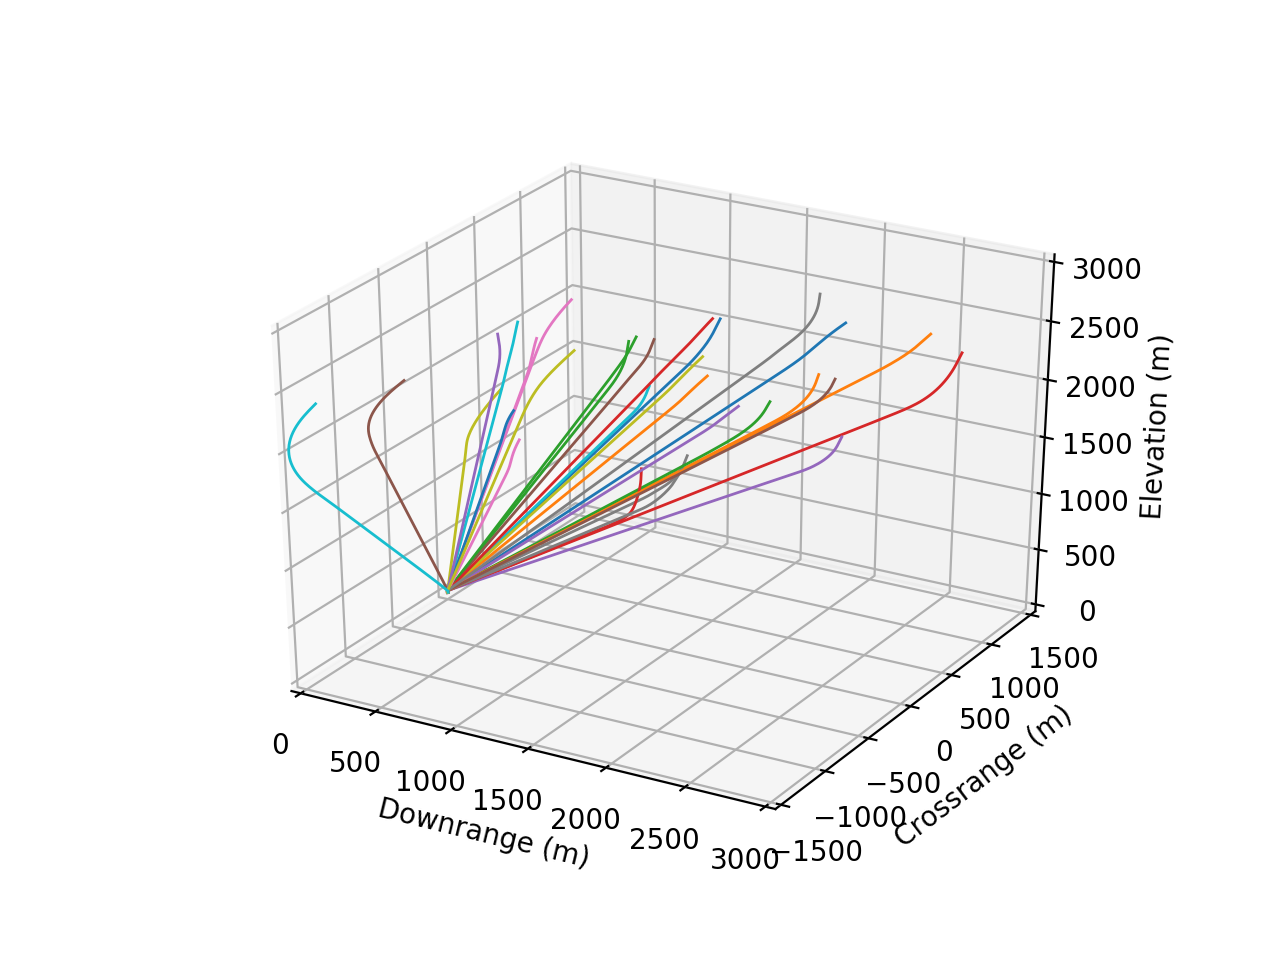

Text(0.0910982,0.0122048,'Elevation (m)')

In [9]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure(11)
ax = fig.gca(projection='3d')

T = env.lander.trajectory_list[0:30]

for t in T:
    plot_traj(ax,t['position'],linewidth=1.0)
ax.legend
fig.canvas.draw()
plt.show()

ax.set_xlim3d(0,3000)
ax.set_ylim3d(-1500,1500)
ax.set_zlim3d(0,3000)

ax.set_xlabel('Downrange (m)')
ax.set_ylabel('Crossrange (m)')
ax.set_zlabel('Elevation (m)')


In [10]:
np.save("trajectory_list.npy",T)

In [13]:
policy.close_sess()


<IPython.core.display.Javascript object>


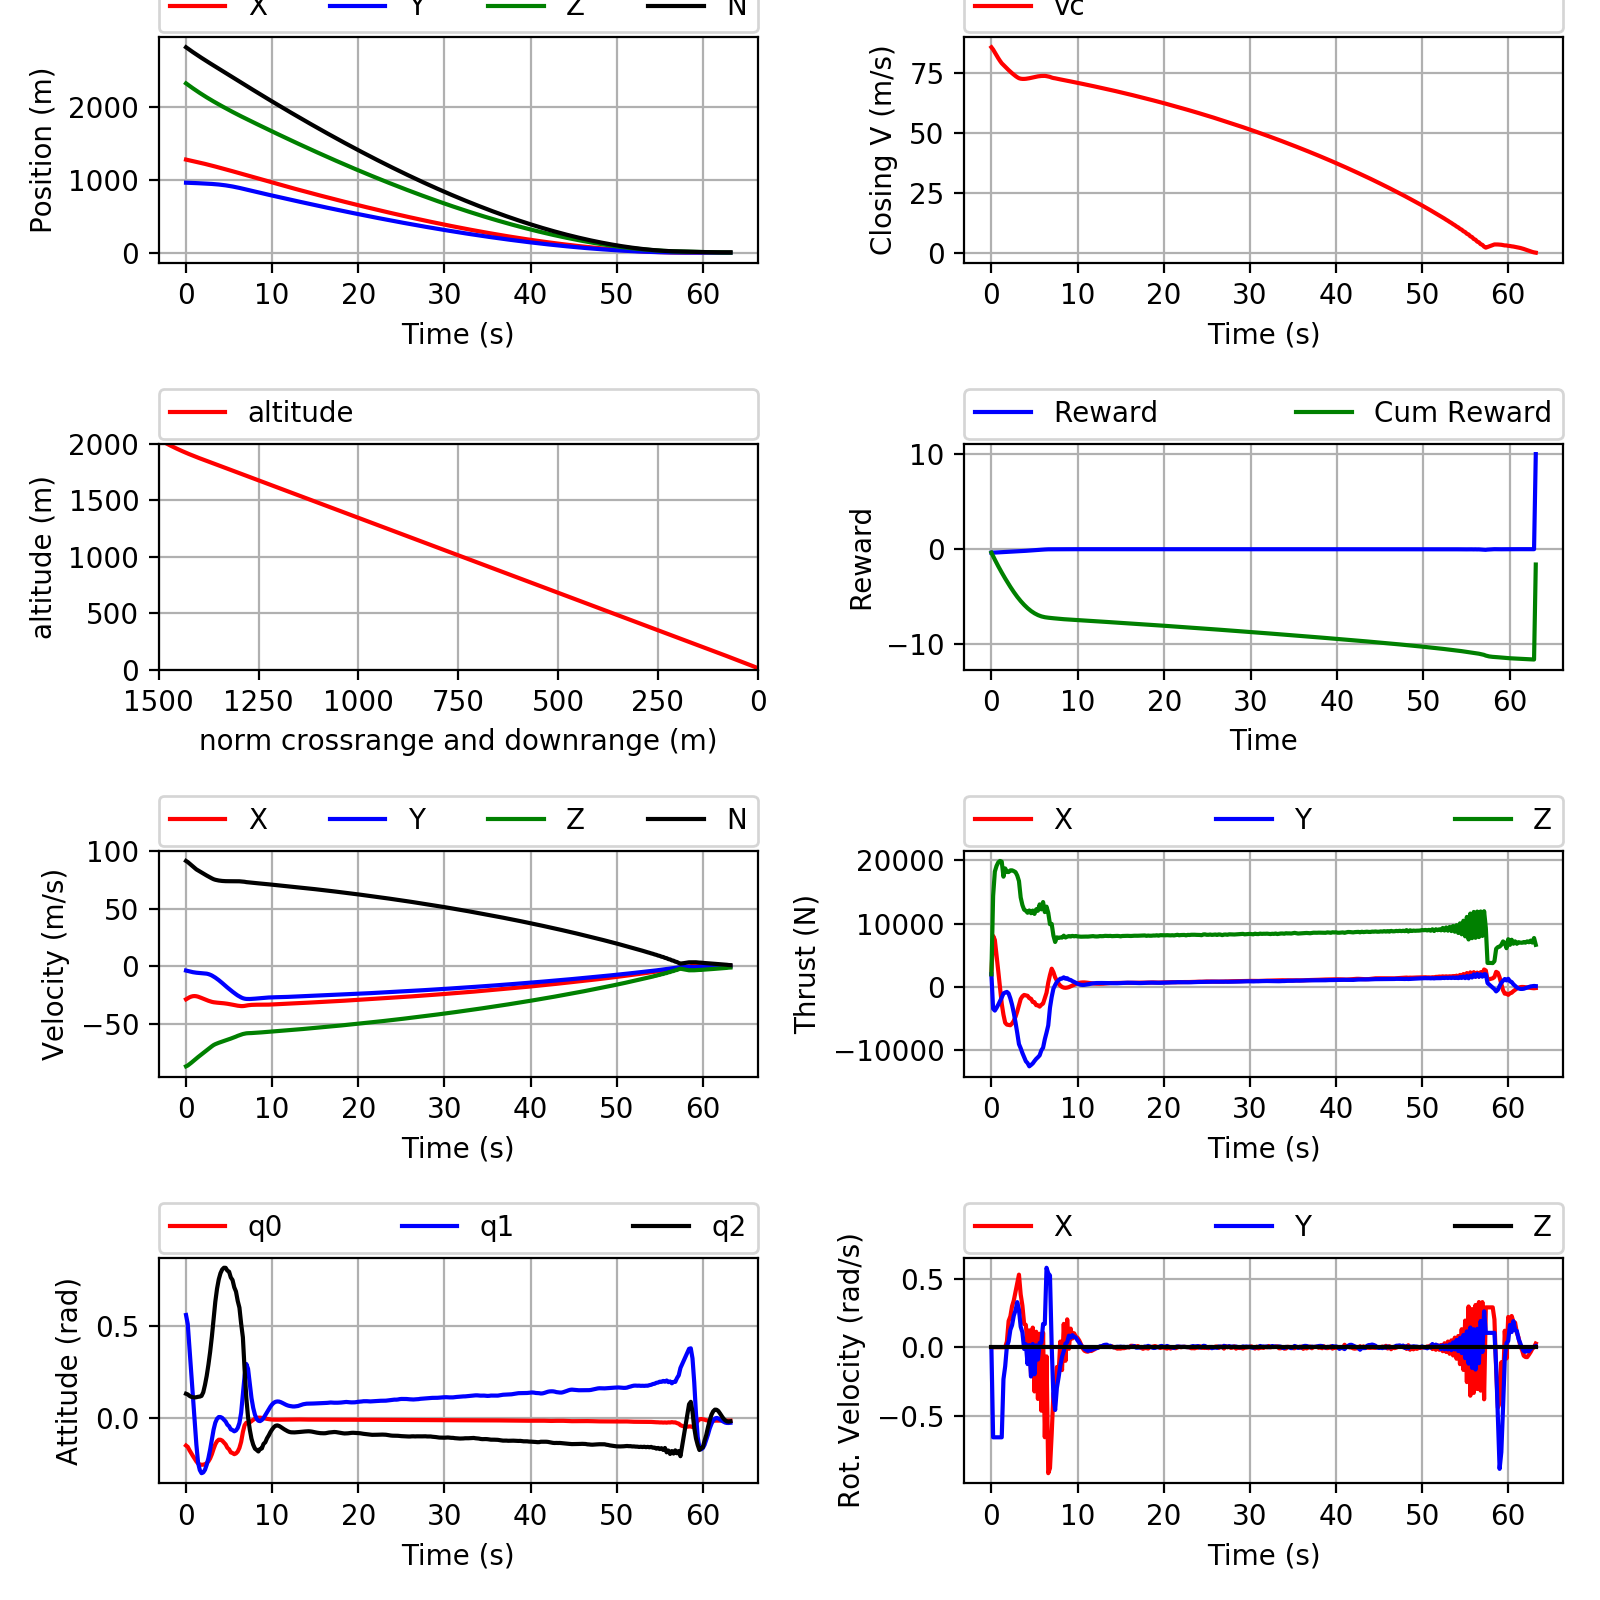

In [12]:
traj = T[0]
envu.render_traj(traj)

In [18]:
foo = np.load("trajectory_list.npy")
traj1 = foo[2]
traj1.keys()


dict_keys(['mass', 'fuel', 'zem', 'reward', 'att_reward', 'w', 'sc_reward', 'bf_thrust', 'dlos', 'glideslope', 'attitude', 'att_penalty', 't', 'v_ratio', 'sc_penalty', 'velocity', 'thrust', 'glideslope_penalty', 'landing_margin', 'attitude_321', 'tracking_reward', 'vc', 'landing_reward', 'glideslope_reward', 'range', 'sc_margin', 'fuel_reward', 'torque', 'los', 'position'])